In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Importando os dados

In [2]:
df = pd.read_csv('./student_habits_performance.csv', sep=',').replace('?', np.nan)
df = df.drop('student_id', axis=1) # there is no need for student_id column
print(df.shape)
df.head()

(1000, 15)


,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


## Análises iniciais

In [3]:
print(list(df.columns))
cat_data = ['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']
num_data = [i for i in list(df.columns) if i not in cat_data]

['age', 'gender', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'part_time_job', 'attendance_percentage', 'sleep_hours', 'diet_quality', 'exercise_frequency', 'parental_education_level', 'internet_quality', 'mental_health_rating', 'extracurricular_participation', 'exam_score']


In [4]:
# detecetando valores faltantes
missing_values = df[df.isnull().any(axis=1)]
print(f'Número de fileiras com células vazias: {missing_values.shape[0]}')
print('Número de células vazias por coluna')
print(df.isnull().sum())

# removendo colunas vazias pois
df = df.dropna()

Número de fileiras com células vazias: 91
Número de células vazias por coluna
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64


In [5]:
for col in cat_data:
    print(f'Quantidade de valores únicos na coluna {col}: {len(df[col].unique())} - {df[col].unique()}')

Quantidade de valores únicos na coluna gender: 3 - ['Female' 'Male' 'Other']
Quantidade de valores únicos na coluna part_time_job: 2 - ['No' 'Yes']
Quantidade de valores únicos na coluna diet_quality: 3 - ['Fair' 'Good' 'Poor']
Quantidade de valores únicos na coluna parental_education_level: 3 - ['Master' 'High School' 'Bachelor']
Quantidade de valores únicos na coluna internet_quality: 3 - ['Average' 'Poor' 'Good']
Quantidade de valores únicos na coluna extracurricular_participation: 2 - ['Yes' 'No']


In [6]:
# convertendo valores categóricos para numéricos
feature_map = {}
for col in cat_data:
    if col in ['diet_quality', 'internet_quality']:
        feature_map[col] = {'Poor': 0, 'Fair': 1, 'Good': 2}
    if col == 'parental_education_level':
        feature_map[col] = {'High School': 0, 'Bachelor': 1, 'Master': 2}
    else:
        feature_map[col] = {unique: i for i, unique in enumerate(list(df[col].unique()))}
    df.loc[:,col] = df.loc[:,col].map(feature_map[col])

feature_map

{'gender': {'Female': 0, 'Male': 1, 'Other': 2},
 'part_time_job': {'No': 0, 'Yes': 1},
 'diet_quality': {'Fair': 0, 'Good': 1, 'Poor': 2},
 'parental_education_level': {'High School': 0, 'Bachelor': 1, 'Master': 2},
 'internet_quality': {'Average': 0, 'Poor': 1, 'Good': 2},
 'extracurricular_participation': {'Yes': 0, 'No': 1}}

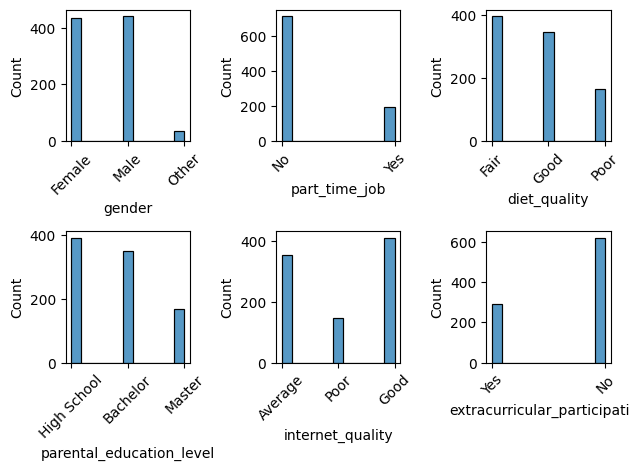

In [7]:
# calculando distribuição para colunas com valores categóricos
fig, axes = plt.subplots(2,3)
axes = axes.flatten()

for i, col in enumerate(cat_data):
    sns.histplot(data=df.loc[:,col], ax=axes[i])
    axes[i].set_xticks(range(len(feature_map[col])), labels=list(feature_map[col].keys()))
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

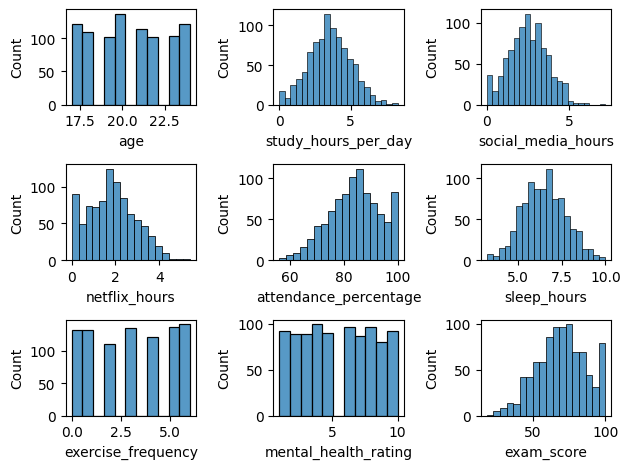

In [8]:
# calculando distribuição para colunas com valores numéricos
fig, axes = plt.subplots(3,3)
axes = axes.flatten()

for i, col in enumerate(num_data):
    sns.histplot(data=df.loc[:,col], ax=axes[i])
    
plt.tight_layout()
plt.show()

In [9]:
print(f'Média de horas diárias de estudo para alunos que não trabalham: {df.loc[df['part_time_job']==0, 'study_hours_per_day'].mean()}')
print(f'Média de horas diárias de estudo para alunos que trabalham: {df.loc[df['part_time_job']==1, 'study_hours_per_day'].mean()}')

Média de horas diárias de estudo para alunos que não trabalham: 3.5562412342215994
Média de horas diárias de estudo para alunos que trabalham: 3.4749999999999996


In [10]:
print(f'Média de horas diárias de estudo para alunos cujos pais só possuem EM: {df.loc[df['parental_education_level']==0, 'study_hours_per_day'].mean()}')
print(f'Média de horas diárias de estudo para alunos cujos pais possuem curso superior: {df.loc[df['parental_education_level']==1, 'study_hours_per_day'].mean()}')
print(f'Média de horas diárias de estudo para alunos cujos pais possuem mestrado: {df.loc[df['parental_education_level']==2, 'study_hours_per_day'].mean()}')

Média de horas diárias de estudo para alunos cujos pais só possuem EM: 3.5512755102040816
Média de horas diárias de estudo para alunos cujos pais possuem curso superior: 3.505142857142858
Média de horas diárias de estudo para alunos cujos pais possuem mestrado: 3.579640718562874


In [11]:
print(f'Média de horas de sono para alunos que não trabalham: {df.loc[df['part_time_job']==0, 'sleep_hours'].mean()}')
print(f'Média de horas de sono para alunos que trabalham: {df.loc[df['part_time_job']==1, 'sleep_hours'].mean()}')

Média de horas de sono para alunos que não trabalham: 6.480224403927068
Média de horas de sono para alunos que trabalham: 6.451530612244898


In [12]:
print(f'Média de horas de saúde mental para alunos que não trabalham: {df.loc[df['part_time_job']==0, 'mental_health_rating'].mean()}')
print(f'Média de horas de saúde mental para alunos que trabalham: {df.loc[df['part_time_job']==1, 'mental_health_rating'].mean()}')

Média de horas de saúde mental para alunos que não trabalham: 5.4446002805049085
Média de horas de saúde mental para alunos que trabalham: 5.545918367346939


In [13]:
print(f'Média de saúde mental diárias de estudo para alunos cujos pais só possuem EM: {df.loc[df['parental_education_level']==0, 'mental_health_rating'].mean()}')
print(f'Média de saúde mental diárias de estudo para alunos cujos pais possuem curso superior: {df.loc[df['parental_education_level']==1, 'mental_health_rating'].mean()}')
print(f'Média de saúde mental diárias de estudo para alunos cujos pais possuem mestrado: {df.loc[df['parental_education_level']==2, 'mental_health_rating'].mean()}')

Média de saúde mental diárias de estudo para alunos cujos pais só possuem EM: 5.4770408163265305
Média de saúde mental diárias de estudo para alunos cujos pais possuem curso superior: 5.734285714285714
Média de saúde mental diárias de estudo para alunos cujos pais possuem mestrado: 4.880239520958084


<Axes: >

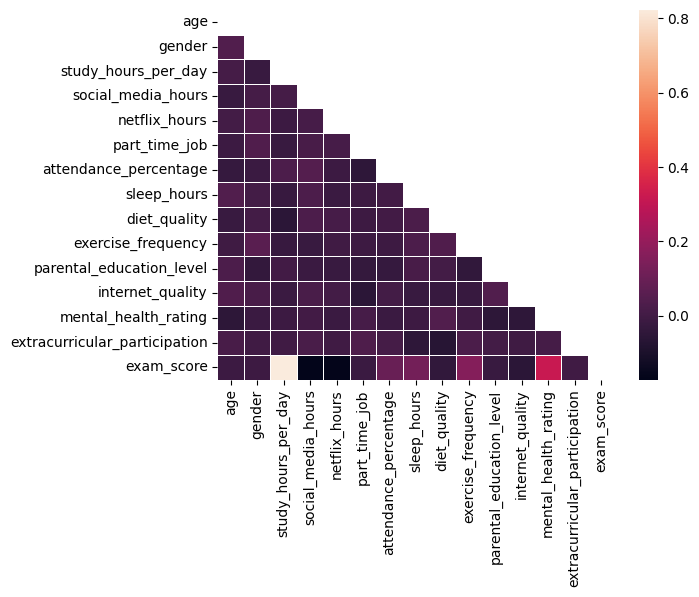

In [14]:
# calculando a correlação
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) # para deixar somente o triângulo abaixo da identidade
sns.heatmap(corr, mask=mask, linewidth=.5)

Podemos ver que há uma correlação entre a qualidade de saude mental e a nota obtida e que há uma forte correlação entre a nota obita e a quantidade de horas estudadas por dia. Vemos também que a média das horas de estudo é bem similar entre os alunos que trabalham e que não trabalham, da mesma forma que essa média é similar para os agrupamentos feitos por nível de escolaridade dos pais.
Vemos também que a média de horas dormidas é bem similar para alunos que trabalham e não trabalham.
Também pode ser observado que média de saúde mental não varia muito entre os alunos que trabalham e não trabalham, porém pode-se notar uma diferença nessa média entre o agrupamento feito por níve de escolaridade dos pais.

Com isso, eu levanto a hipótese de que o desempenho escolar dos estudantes depende somente da quantidade de horas estudadas por dia e do estado de saúde do estudante

## Definindo o modelo

Modelo implementado baseado no pseudo-código disponibilizado em [wiki/K-means_clustering](https://en.wikipedia.org/wiki/K-means_clustering)

Cogitei utilizar a abordagem de inicialização dos centroides k-means++, mas simplesmente não deu tempo. Links de referência:
- https://stackoverflow.com/a/35952274
- http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf

Como não implementei a inicialização k-means++, mas também não queria usar pontos aletaórios, os centroides iniciais são definidos como k pontos aleatórios dentre os que já existem em nosso dataset

In [15]:
def distance(point_a, point_b):
    return np.sqrt(np.sum((point_a-point_b)**2))

def calculate_centroid(cluster):
    return np.mean(cluster, axis=0)

def k_means_cluster(k, points, max_iter=300):
    centroids = points[np.random.randint(points.shape[0], size=k)] # pega pontos aleatórios dentro do dataset

    converged = False
    iter_count = 0 # contador de iterações
    labels = np.zeros(points.shape[0]) # grupo ao qual cada ponto pertence
    
    while (not converged) and (iter_count < max_iter):
        clusters = [[] for _ in range(k)] # inicialização dos clusters
        
        for idx, point in enumerate(points):
            dist_centroid = [distance(point, centroid) for centroid in centroids] # distances_to_each_centroid
            nearest_cluster = np.argmin(dist_centroid)
            labels[idx] = nearest_cluster
            clusters[nearest_cluster].append(point)
            
        new_centroids = [calculate_centroid(cluster) for cluster in clusters]
        converged = np.allclose(new_centroids, centroids) # checa se é o mesmo ponto
        centroids = new_centroids
        iter_count += 1

    return clusters, labels

## Clusterização

In [16]:
# normalizando dados
df_norm = preprocessing.normalize(df)

In [19]:
# encontrando melhor K
score = []
for k in range(2,10):
    clusters, labels = k_means_cluster(k, df_norm)
    score.append(silhouette_score(df_norm, labels))

In [22]:
for i, scr in enumerate(score):
    # melhor valor é 1, pior valor é -1
    # valores próximos de 0 indicam que há sobreposição de clusters
    print(f'Score obtido para {i+2} clusters: {scr:.3f}')

Score obtido para 2 clusters: 0.459
Score obtido para 3 clusters: 0.371
Score obtido para 4 clusters: 0.313
Score obtido para 5 clusters: 0.264
Score obtido para 6 clusters: 0.233
Score obtido para 7 clusters: 0.222
Score obtido para 8 clusters: 0.193
Score obtido para 9 clusters: 0.191


### Aplicando PCA

In [ ]:
# standartizando
X = StandardScaler().fit_transform(df.iloc[:,:-1])
y = df.iloc[:,-1]

In [28]:
pca = PCA(n_components=0.75)
pca_data = pca.fit_transform(df_norm)

In [29]:
# encontrando melhor K
score = []
for k in range(2,10):
    clusters, labels = k_means_cluster(k, pca_data)
    score.append(silhouette_score(df_norm, labels))

for i, scr in enumerate(score):
    # melhor valor é 1, pior valor é -1
    # valores próximos de 0 indicam que há sobreposição de clusters
    print(f'Score obtido para {i+2} clusters: {scr:.3f}') # não melhorou com pca

Score obtido para 2 clusters: 0.459
Score obtido para 3 clusters: 0.371
Score obtido para 4 clusters: 0.313
Score obtido para 5 clusters: 0.258
Score obtido para 6 clusters: 0.233
Score obtido para 7 clusters: 0.196
Score obtido para 8 clusters: 0.183
Score obtido para 9 clusters: 0.152


## Comentários finais

Ok, talvez aqui eu tenha falhando imensamente na questão de hipótese kkkk. A hipótese que levantei era relacionada às variáveis mais importantes para a definição da nota obtida pelo aluno, mas acho que eu deveria ter elaborado algo relacionado à quantidade de grupos que existem dentro dos dados. Com base nos resultados, podemos ver que a melhor quantidade de clusters é 2. O que faz sentido se olharmos pela perpectiva de a variável que possui maior correlação com a nota é a quantidade de horas de estudo diárias, poderíamos então separar entre os grupos de "não estudam/estudam pouco" e "estudam muito"

In [33]:
clusters, labels = k_means_cluster(2, df_norm)

mean_study_h_0 = df.loc[labels==0,'study_hours_per_day'].mean()
mean_study_h_1 = df.loc[labels==1,'study_hours_per_day'].mean()
print(f'Média de horas de estudo para o grupo 0: {mean_study_h_0:.2f}')
print(f'Média de horas de estudo para o grupo 1: {mean_study_h_1:.2f}')

Média de horas de estudo para o grupo 0: 2.45
Média de horas de estudo para o grupo 1: 4.29
